# Make the splits for task 1 (protein extrapolation)

For this set we want to perform enzyme classification and make training and testing for different levels of challenge.

### Task A: Predicting easily misclassified enzymes
Here we aim to use the Price et al, dataset which includes 149 enzymes which were challenging to discern the activity of (Mutant phenotypes for thousands of bacterial genes of unknown function). 

### Task B: Predicting Promiscuous enzymes
Being able to classify enzymes that are able to catalyse multiple reactions remains a challenge, so we test these separately. 

### Task C: Predicting enzymes with low sequence identity 
Given many enzymes share high sequence similarity, we sought to investigate the efficacy of each method using sequnces with 30 and 50% siumilarity.

### Lastly check the sequence identity using blast for each one in the train and test

In [33]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
swissprot = pd.read_csv('../processed_data/protein2EC.csv')

In [36]:
swissprot['EC1'].nunique()
swissprot['EC2'].nunique()
swissprot['EC3'].nunique()
swissprot['EC number'].nunique()

7

In [32]:
### Also make a clustered version of the training set at 50% sequence identity, for training and to reduce the number of the samples to extract

np.random.seed(42)
random.seed(42)
swissprot50 = swissprot.groupby('clusterRes50').sample(1)
swissprot50.to_csv('../processed_data/protein2EC_clustered50.csv', index=False)

## Task A: challenging enzymes

The price dataset was downloaded from: https://github.com/tttianhao/CLEAN/blob/main/app/data/price.fasta

In [5]:
price = pd.read_csv('raw_data/price.tsv', sep='\t')
#remove sequences in price that are in swissprot
price = price[~price['Sequence'].isin(swissprot['Sequence'])]
price['Length'] = price['Sequence'].apply(len)
price = price[price['Length'] > 100]
price = price[price['Length'] < 650]
price.to_csv('../splits/task1/price_protein_test.csv', index=False)
price

,Entry,EC number,Sequence,Length
0,WP_063460136,5.3.1.7,MAIPPYPDFRSAAFLRQHLRATMAFYDPVATDASGGQFHFFLDDGT...,424
1,WP_063462980,4.2.1.43,VPTTFHEDGTLDLDSQKRCLDFMIDAGVDGVCILANFSEQFSLSDA...,294
2,WP_063462990,1.1.1.48,LIDCNIDMTQLFAPSSSSTDATGAPQGLAKFPSLQGRAVFVTGGGS...,280
3,WP_041412631,4.2.1.25,MCLGRRRCHMNNKKPKTLRSASWFGSDDKNGFMYRSWMKNQGIPEH...,586
4,WP_011717048,5.1.3.3,MQLSVTQKSLQHAAFADELQLVTLTNSHGLEVVLSNYGASIWSVKL...,351
...,...,...,...,...
144,WP_010207013,1.3.8.7,MADYKAPLRDMRFVLNEVFEVATTWAQLPALADTVDAETVEAILEE...,592
145,WP_010207016,1.3.8.7,MPDYKAPLRDIRFVRDELLGYEAHYQSLPACQDATPDMVDAILEEG...,601
146,WP_010207340,2.6.1.19,MSSNNPQTREWQALSSDHHLAPFSDFKQLKEKGPRIITKAHGVYLW...,454
147,WP_010207341,6.3.1.11,MSVPPRAVQLNEANAFLKDHPEVLYVDLLIADMNGVVRGKRIERTS...,458


## Task 2: Selecting low sequence identity proteins

We test two levels of sequnece identity: < 30% and 30-50%.

In [6]:
swissprot['clusterRes50'].value_counts()

clusterRes50
Q4A604    814
B1YLD8    693
Q2RGU9    672
Q1D345    621
A9ISZ5    608
         ... 
O42912      1
O42951      1
O43014      1
O43090      1
Q9J5H2      1
Name: count, Length: 25739, dtype: int64

In [7]:
swissprot['clusterRes30'].value_counts()

clusterRes30
B7JVV5    1352
Q8CXP9    1016
Q2JA12     853
Q8D3J3     815
Q8EJM1     788
          ... 
Q9I739       1
Q9I7C1       1
Q9K499       1
Q9KJE8       1
Q9J5H2       1
Name: count, Length: 9012, dtype: int64

In [8]:
swissprot['clusterRes70'].value_counts()

clusterRes70
Q7V2D0    526
P31293    271
Q0P3P2    234
C3K1E6    176
Q2VZN2    170
         ... 
P15567      1
P15688      1
P15689      1
P15722      1
Q9J5H2      1
Name: count, Length: 61736, dtype: int64

In [9]:
swissprot['clusterRes90'].value_counts()

clusterRes90
P31184    434
A4QLB3    112
B1VKF9     98
Q06GR5     81
B5F8J0     69
         ... 
F6HDM2      1
F6H2F8      1
F6D9Q8      1
F6D512      1
Q9J5H2      1
Name: count, Length: 106727, dtype: int64

## Make a very hard set of sequences which have no entries that are < 30% identity

In [10]:
swissprot['Duplicated clusterRes30'] = swissprot['clusterRes30'].duplicated(keep=False)
swissprot['Duplicated clusterRes50'] = swissprot['clusterRes50'].duplicated(keep=False)
swissprot['Duplicated clusterRes70'] = swissprot['clusterRes70'].duplicated(keep=False)
swissprot['Duplicated clusterRes90'] = swissprot['clusterRes90'].duplicated(keep=False)
swissprot['Duplicated EC'] = swissprot['EC number'].duplicated(keep=False)
swissprot['Promiscuous'] = swissprot['Sequence'].duplicated(keep=False)
not_promiscuous = swissprot[~swissprot['Promiscuous']]

In [11]:
from sciutil import SciUtil

u = SciUtil()

np.random.seed(42)
random.seed(42)

train_isolated30 = not_promiscuous[not_promiscuous['Duplicated clusterRes30'] == False]
train_isolated30 = train_isolated30[train_isolated30['Duplicated EC'] == True]
# Make a validation set that is completely held out.

#sample a random one from each unique EC at level 3 for validation (i.e. not in training or the larger test set)
validation_30 = train_isolated30.groupby('EC3').sample(1)

u.dp(['Training: ', len(train_isolated30), 'Validation:', len(validation_30)])

--------------------------------------------------------------------------------
                        Training: 	2847	Validation:	175	                        
--------------------------------------------------------------------------------


In [12]:
train_isolated30['clusterRes30'].value_counts()

clusterRes30
A0A075BSX9    1
Q54PB4        1
Q555N7        1
Q556Y7        1
Q557H5        1
             ..
Q3ZE13        1
Q44493        1
Q45FA5        1
Q46507        1
Q9J5H2        1
Name: count, Length: 2847, dtype: int64

In [13]:
np.random.seed(42)
random.seed(42)

# Drop out the ones we picked from the train30 just to make sure we're getting a diverse set
train_isolated50 = not_promiscuous[not_promiscuous['Duplicated clusterRes50'] == False]
train_isolated50 = train_isolated50[train_isolated50['Duplicated EC'] == True]

train_isolated50 = train_isolated50[~train_isolated50['Entry'].isin(train_isolated30['Entry'].values)]

# Make a validation set that is completely held out.
np.random.seed(42)
random.seed(42)

#sample a random one from each unique EC at level 3 for validation (i.e. not in training or the larger test set)
validation_50 = train_isolated50.groupby('EC3').sample(1)

u.dp(['Training set 50%: ', len(train_isolated50), 'Validation:', len(validation_50)])

--------------------------------------------------------------------------------
                    Training set 50%: 	8419	Validation:	196	                    
--------------------------------------------------------------------------------


In [14]:
np.random.seed(42)
random.seed(42)

# Drop out the ones we picked from the train30 just to make sure we're getting a diverse set
train_isolated70 = not_promiscuous[not_promiscuous['Duplicated clusterRes70'] == False]
train_isolated70 = train_isolated70[train_isolated70['Duplicated EC'] == True]

train_isolated70 = train_isolated70[~train_isolated70['Entry'].isin(train_isolated50['Entry'].values)]
train_isolated70 = train_isolated70[~train_isolated70['Entry'].isin(train_isolated30['Entry'].values)]

# Make a validation set that is completely held out.
np.random.seed(42)
random.seed(42)

#sample a random one from each unique EC at level 3 for validation (i.e. not in training or the larger test set)
validation_70 = train_isolated70.groupby('EC3').sample(1)

u.dp(['Training set 70%: ', len(train_isolated70), 'Validation:', len(validation_70)])

--------------------------------------------------------------------------------
                   Training set 70%: 	25525	Validation:	204	                    
--------------------------------------------------------------------------------


In [15]:
np.random.seed(42)
random.seed(42)

train_isolated90 = not_promiscuous[not_promiscuous['Duplicated clusterRes90'] == False]
train_isolated90 = train_isolated90[train_isolated90['Duplicated EC'] == True]

print(len(train_isolated90))
train_isolated90 = train_isolated90[~train_isolated90['Entry'].isin(train_isolated70['Entry'].values)]
print(len(train_isolated90))
train_isolated90 = train_isolated90[~train_isolated90['Entry'].isin(train_isolated30['Entry'].values)]
print(len(train_isolated90))
train_isolated90 = train_isolated90[~train_isolated90['Entry'].isin(train_isolated50['Entry'].values)]

# Make a validation set that is completely held out.
np.random.seed(42)
random.seed(42)

#sample a random one from each unique EC at level 3 for validation (i.e. not in training or the larger test set)
validation_90 = train_isolated90.groupby('EC3').sample(1)

u.dp(['Training set 90%: ', len(validation_90), 'Validation:', len(validation_90)])

79119


53598
50751
--------------------------------------------------------------------------------
                    Training set 90%: 	206	Validation:	206	                     
--------------------------------------------------------------------------------


# Add in for 70 and 90% identity

## Task 3: Promiscuous enzymes

Here we want to look at the promiscuous enzymes and see how well they can be classfiied 


In [22]:
promiscuous = swissprot[swissprot['Promiscuous']]
# promiscuous = promiscuous[promiscuous['Duplicated clusterRes90'] == False] #prevent sequence identity from being too high, but then nothing comes out
promiscuous = promiscuous.groupby(['Entry', 'Sequence']).agg({'EC number': lambda x: list(x)}).reset_index()
promiscuous

,Entry,Sequence,EC number
0,A0A023GS28,MAPTKDFSTTTTNGAESWDDVADFVTKKGHGVKGLSERGIKTLPKP...,"[1.14.11.61, 1.14.11.62]"
1,A0A023GS29,MAPTKDFSTATNGADSWDDVADFVTKKGHGVKGLSERGIKTLPKPF...,"[1.14.11.61, 1.14.11.62]"
2,A0A061B0Q2,MFKPTRVLKSSQPILNSLPHAETVKMAYDLHLPKKTLHQNMNITSD...,"[2.3.1.268, 3.1.2.1]"
3,A0A068Q609,MALLTLFNQIWQEGQLQSSTSSFNIFLVPILCLSIFILFSLTRSSS...,"[1.14.14.44, 1.14.14.77]"
4,A0A075FBG7,MSITFNLKIAPFSGPGIQRSKETFPATEIQITASTKSTMTTKCSFN...,"[4.2.3.131, 4.2.3.189, 4.2.3.190]"
...,...,...,...
8486,W0T4A7,MLLAYTVRPSNWSFTRRAYSATARAFNQQKGLLPLPIKETVDMAYD...,"[2.3.1.268, 3.1.2.1]"
8487,W0W999,MAANGSQRPIIAFMSDLGTTDDSVAQCKGLMHSICPGVTVVDVCHS...,"[2.5.1.63, 2.5.1.94]"
8488,W5QJZ5,MAPTKDSVIHMGAESWDEISEFVTKKGHGVKGLSELGIKTLPKQFH...,"[1.14.11.61, 1.14.11.62]"
8489,W6HUT3,MSVSLSFAASATFGFRGGLGGFSRPAAAIKQWRCLPRIQCHSAEQS...,"[4.2.3.113, 4.2.3.114, 4.2.3.115, 4.2.3.15]"


In [23]:
def get_difference_level(predicted_ECs):
    counters = []

    for true_EC in predicted_ECs:

        #convert true_EC to a list
        if type(predicted_ECs) == str:
            predicted_ECs = [predicted_ECs]
        true_split = true_EC.split('.')

        for predicted in predicted_ECs:
            #print(true_EC)
            
            predicted_split = predicted.split('.')
            counter = 0
            for predicted, true in zip(predicted_split, true_split):
                if predicted == true:
                    counter += 1
                else:
                    break
            counters.append(4 - counter)

    return np.max(counters)

In [24]:
promiscuous['Surprise Level'] = promiscuous['EC number'].apply(get_difference_level)
promiscuous['Number of ECs'] = promiscuous['EC number'].apply(lambda x: len(x))
# Check if there are duplicates in terms of EC and sequence
promiscuous['Duplicated EC'] = promiscuous['EC number'].duplicated(keep=False)
promiscuous['Duplicated Sequence'] = promiscuous['Sequence'].duplicated(keep=False)
promiscuous = promiscuous.sort_values(['Duplicated EC', 'Surprise Level', 'Number of ECs'], ascending=False)
promiscuous

,Entry,Sequence,EC number,Surprise Level,Number of ECs,Duplicated EC,Duplicated Sequence
4647,Q1EG72,MAAPTLTTDGPRLGQQEMKKMSPSFHPTLWGDFFLSYEAPTEAQEA...,"[4.2.3.113, 4.2.3.15, 4.2.3.16, 4.2.3.25, 4.2....",4,6,True,False
5923,Q5GJ60,MAAPTLTADGPRLGQQEMKKMSPSFHPTLWGDFFLSYEAPTEAQEA...,"[4.2.3.113, 4.2.3.15, 4.2.3.16, 4.2.3.25, 4.2....",4,6,True,False
3274,P13437,MALLRGVFIVAAKRTPFGAYGGLLKDFTATDLTEFAARAALSAGKV...,"[2.3.1.16, 2.3.1.9, 3.1.2.1, 3.1.2.2]",4,4,True,False
3281,P14060,MTGWSCLVTGAGGFLGQRIIRLLVKEKELKEIRVLDKAFGPELREE...,"[1.1.1.145, 1.1.1.210, 1.1.1.270, 5.3.3.1]",4,4,True,False
3391,P22071,MPGWSCLVTGAGGFVGQRIIRMLVQEKELQEVRALDKVFRPETKEE...,"[1.1.1.145, 1.1.1.210, 1.1.1.270, 5.3.3.1]",4,4,True,False
...,...,...,...,...,...,...,...
4096,P9WNX9,MPIATINPATGETVKTFTAATDDEVDAAIARAHRRFADYRQTSFAQ...,[1.2.1.79],0,1,False,True
4373,Q0KBD1,MPRFAANLSMMYNEHAFLDRFAAAAADGFRAVEFLFPYEHAAAELR...,[5.3.1.35],0,1,False,True
5480,Q44015,MPRFAANLSMMYNEHAFLDRFAAAAADGFRAVEFLFPYEHAAAELR...,[5.3.1.22],0,1,False,True
6666,Q72K55,MDYGMYFFEHVTPYETLVRRMERVIASGKTPFQDYFLFESKGFGKV...,[2.5.1.16],0,1,False,True


## Potentially remove duplicated sequneces for promiscous enzymes that have similar reactions

In [25]:
# Keep ones which have duplicated ECs so that there is a homolog in the training dataaste
promiscuous = promiscuous[promiscuous['Duplicated EC'] == True]
# Make a validation set that is completely held out.
np.random.seed(42)
random.seed(42)

# Make this so that we can just sample a single one
promiscuous['EC number'] = [';'.join(sorted(ecs)) for ecs in promiscuous['EC number']]

#sample a random one from each unique EC at level 3 for validation (i.e. not in training or the larger test set)
promiscuous = promiscuous.groupby('EC number').sample(1)
#promiscuous.drop_duplicates(subset='EC number', inplace=True)
promiscuous.reset_index(inplace=True)
promiscuous

/tmp/ipykernel_614599/717349449.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promiscuous['EC number'] = [';'.join(sorted(ecs)) for ecs in promiscuous['EC number']]


,index,Entry,Sequence,EC number,Surprise Level,Number of ECs,Duplicated EC,Duplicated Sequence
0,4072,P9WGT3,MTATATEGAKPPFVSRSVLVTGGNRGIGLAIAQRLAADGHKVAVTH...,1.1.1.100;1.1.1.36,1,2,True,False
1,6834,Q7TS56,MDKVCAVFGGSRGIGKAVAQLMAQKGYRLAIVARNLEVAKATASEL...,1.1.1.100;1.6.5.10,3,2,True,False
2,4267,Q09851,MEAEKFVLITGCSEGGIGNALALKFHQEGFQVLATARQVERMDNLT...,1.1.1.101;3.1.1.3,4,2,True,False
3,7381,Q8JZV9,MGRLDGKVIVLTAAAQGIGRASALAFAREGAKVIATDINESKLQEL...,1.1.1.104;1.1.1.30,1,2,True,False
4,8233,Q9R092,MWFYLVTLVGLYHLLRWYRERQVVSHLQDKYVFITGCDSGFGNLLA...,1.1.1.105;1.1.1.209;1.1.1.239;1.1.1.53;1.1.1.62,1,5,True,False
...,...,...,...,...,...,...,...,...
534,6724,Q75UN0,MALEILGVEGIPEVDAGADLAGLIAKAGTYRDGDILLVTSKVVSKA...,6.3.2.31;6.3.2.34,1,2,True,False
535,7378,Q8IXN7,MCSQLWFLTDRRIREDYPQVQILRALRQRCSEQDVRFRAVLMDQIA...,6.3.2.41;6.3.2.42,1,2,True,False
536,7536,Q8TWX0,MPETPNKVLIIGSGPIIVGQAAEFDYSGSQACKALREEGVEVVLVN...,6.3.4.16;6.3.5.5,2,2,True,False
537,100,A0K6Q0,MFTARIARSMASESAPAASSVAPGSSGAPMADCVLEVRGVGKSFPG...,7.5.2.11;7.5.2.7,1,2,True,False


In [26]:
promiscuous = promiscuous[promiscuous['Surprise Level'] >= 2]
promiscuous = promiscuous[promiscuous['Duplicated EC']]
promiscuous

,index,Entry,Sequence,EC number,Surprise Level,Number of ECs,Duplicated EC,Duplicated Sequence
1,6834,Q7TS56,MDKVCAVFGGSRGIGKAVAQLMAQKGYRLAIVARNLEVAKATASEL...,1.1.1.100;1.6.5.10,3,2,True,False
2,4267,Q09851,MEAEKFVLITGCSEGGIGNALALKFHQEGFQVLATARQVERMDNLT...,1.1.1.101;3.1.1.3,4,2,True,False
8,7784,Q95JH7,MDSKHQCVKLNDGHFMPVLGFGTYAPAEVPKNKALEATKLAIEAGF...,1.1.1.112;1.1.1.149;1.1.1.209;1.1.1.210;1.1.1....,3,9,True,False
11,3391,P22071,MPGWSCLVTGAGGFVGQRIIRMLVQEKELQEVRALDKVFRPETKEE...,1.1.1.145;1.1.1.210;1.1.1.270;5.3.3.1,4,4,True,False
12,8380,Q9XWF0,MSIKRLSMRLKKGIHRSWNRMTSLEAGLEEEKEIKIVEEPEPRPWK...,1.1.1.145;5.3.3.1,4,2,True,False
...,...,...,...,...,...,...,...,...
504,4717,Q1LRV9,MPHAHPADIDGHHLTPDTVAAIARGQRAAIVPEPVLGKVADARARF...,4.3.1.23;5.4.3.6,4,2,True,False
515,3506,P30904,MPMFIVNTNVPRASVPEGFLSELTQQLAQATGKPAQYIAVHVVPDQ...,5.3.2.1;5.3.3.12,2,2,True,False
531,3236,P10378,MSIPFTRWPEEFARRYREKGYWQDLPLTDILTRHAASDSIAVIDGE...,6.2.1.71;6.3.2.14,3,2,True,False
532,6973,Q80WS1,MCSSVTGKLWFLTDRRIREDYPQKEILRALKAKCCEEELDFRAVVM...,6.3.1.17;6.3.2.41,2,2,True,False


## Create a training dataset that doesn't include any of our proteins for validation

Check for the sequences before we can use them for training.

In [27]:
test_pooled_seqs = pd.concat([validation_30, validation_50, validation_70, validation_90, price, promiscuous])['Sequence'].unique()
len(test_pooled_seqs)

1106

In [28]:
#remove from the training set
train_swissprot = swissprot[~swissprot['Sequence'].isin(test_pooled_seqs)]
train_swissprot

,Entry,Entry Name,Sequence,EC number,Length,EC All,clusterRes50,clusterRes30,clusterRes70,clusterRes90,EC3,EC2,EC1,Duplicated clusterRes30,Duplicated clusterRes50,Duplicated clusterRes70,Duplicated clusterRes90,Duplicated EC,Promiscuous
0,A0A009IHW8,ABTIR_ACIB9,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,269,3.2.2.-; 3.2.2.6,A0A009IHW8,A1AY86,A0A009IHW8,A0A009IHW8,3.2.2,3.2,3,True,False,False,False,True,False
1,A0A024SC78,CUTI1_HYPJR,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74,248,3.1.1.74,A8QPD8,A8QPD8,A8QPD8,A0A024SC78,3.1.1,3.1,3,True,True,True,False,True,False
2,A0A024SH76,GUX2_HYPJR,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91,471,3.2.1.91,B2ABX7,B2AE04,A0A024SH76,A0A024SH76,3.2.1,3.2,3,True,True,False,False,True,False
3,A0A059TC02,CCR1_PETHY,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...,1.2.1.44,333,1.2.1.44,Q6K9A2,Q5FB34,Q9S9N9,A0A059TC02,1.2.1,1.2,1,True,True,True,False,True,False
4,A0A067XGX8,AROG2_PETHY,MALTATATTRGGSALPNSCLQTPKFQSLQKPTFISSFPTNKKTKPR...,2.5.1.54,512,2.5.1.54,P80574,P80576,Q75W16,A0A067XGX8,2.5.1,2.5,2,True,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169860,Q05115,AMDA_BORBO,MQQASTPTIGMIVPPAAGLVPADGARLYPDLPFIASGLGLGSVTPE...,4.1.1.76,240,4.1.1.76,Q05115,Q05115,Q05115,Q05115,4.1.1,4.1,4,False,False,False,False,False,False
169861,Q6HX62,Y3032_BACAN,MGQNQFRWSNEQLREHVEIIDGTRSPHKLLKNATYLNSYIREWMQA...,3.5.4.2,584,3.5.4.2,Q6HX62,O34909,Q81BX6,Q6HX62,3.5.4,3.5,3,True,True,True,False,True,False
169862,Q6L032,Y1085_PICTO,MLLKNIKISNDYNIFMIIASRKPSLKDIYKIIKVSKFDEPADLIIE...,3.5.4.2,573,3.5.4.2,Q6L032,O34909,Q6L032,Q6L032,3.5.4,3.5,3,True,False,False,False,True,False
169863,Q94MV8,VG56_BPLZ5,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,172,3.6.1.12,P39262,P39262,Q94MV8,Q94MV8,3.6.1,3.6,3,True,True,False,False,True,False


In [29]:
#save all of the generated splits
train_swissprot.iloc[:,:-6].to_csv('../splits/task1/protein_train.csv')
validation_30.iloc[:,:-6].to_csv('../splits/task1/30_protein_test.csv', index=False)
validation_50.iloc[:,:-6].to_csv('../splits/task1/30-50_protein_test.csv', index=False)
validation_70.iloc[:,:-6].to_csv('../splits/task1/50-70_protein_test.csv', index=False)
validation_90.iloc[:,:-6].to_csv('../splits/task1/70-90_protein_test.csv', index=False)
price.to_csv('../splits/task1/price_protein_test.csv', index=False)
promiscuous.to_csv('../splits/task1/promiscuous_protein_test.csv', index=False)

#print the length of every saved file
for split in [train_swissprot, validation_30, validation_50, validation_70, validation_90, price, promiscuous]:
    print(len(split))

168682
175
196
204
206
146
179


## Check the test set similarities/contamination to the training set

For this, we seek to check if there are sequences with very high similarity in the training set. To do this, we use npyblast to get the highest match.

In [93]:
def save_seqs_as_fasta(df, filename):
    with open(filename, 'w+') as fout:
        for entry, seq in df[['Entry', 'Sequence']].values:
            fout.write(f'>{entry}\n{seq}\n')

save_seqs_as_fasta(validation_30, f'../processed_data/validation_30.fasta')
save_seqs_as_fasta(validation_50, f'../processed_data/validation_50.fasta')
save_seqs_as_fasta(validation_70, f'../processed_data/validation_70.fasta')
save_seqs_as_fasta(validation_90, f'../processed_data/validation_90.fasta')
save_seqs_as_fasta(price, f'../processed_data/price.fasta')
save_seqs_as_fasta(promiscuous, f'../processed_data/promiscuous.fasta')


In [95]:
save_seqs_as_fasta(train_swissprot, f'../processed_data/train_swissprot.fasta')


   Read database: 100.0% (58 MB)                    
Analyze database: 100.0% (168k)                    
  Index database: 100.0% (168k)                    
    Read queries: 100.0% (59 kB)                      
 Search database: 100.0% (175.0)                    


Text(0.5, 1.0, '30% similarity')

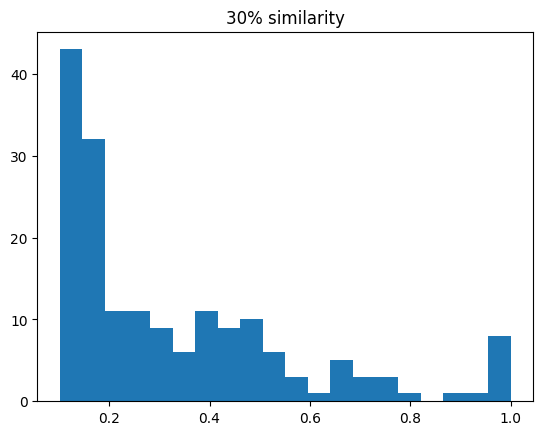

In [57]:
# Lets also look at the protein our query is the query genome and our database is going to be ecoli.
results_prot = npy.blast(query=f'../processed_data/validation_30.fasta',
                         database=f'../processed_data/train_swissprot.fasta',
                         minIdentity=0.1,
                         maxAccepts=1,
                         alphabet="protein")
results = pd.DataFrame(results_prot)  # Convert this into a dataframe so that we can see it more easily
plt.hist(results['Identity'], bins=20)
plt.title('30% similarity')


   Read database: 100.0% (58 MB)                    
Analyze database: 100.0% (168k)                    
  Index database: 100.0% (168k)                    
    Read queries: 100.0% (74 kB)                      
 Search database: 100.0% (196.0)                    


Text(0.5, 1.0, '50% similarity')

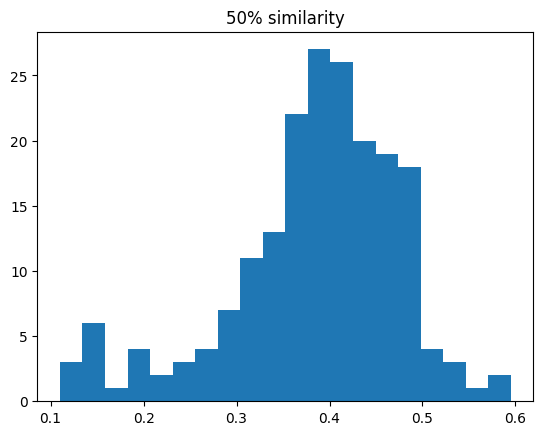

In [58]:
# Lets also look at the protein our query is the query genome and our database is going to be ecoli.
results_prot = npy.blast(query=f'../processed_data/validation_50.fasta',
                         database=f'../processed_data/train_swissprot.fasta',
                         minIdentity=0.,
                         maxAccepts=1,
                         alphabet="protein")
results = pd.DataFrame(results_prot)  # Convert this into a dataframe so that we can see it more easily
plt.hist(results['Identity'], bins=20)
plt.title('50% similarity')


   Read database: 100.0% (58 MB)                    
Analyze database: 100.0% (168k)                    
  Index database: 100.0% (168k)                    
    Read queries: 100.0% (74 kB)                      
 Search database: 100.0% (204.0)                    


Text(0.5, 1.0, '70% similarity')

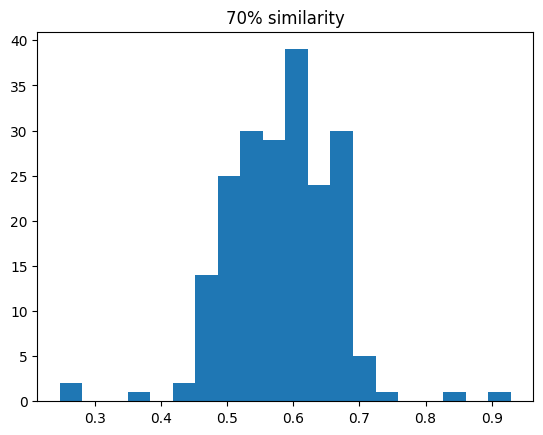

In [59]:

# Lets also look at the protein our query is the query genome and our database is going to be ecoli.
results_prot = npy.blast(query=f'../processed_data/validation_70.fasta',
                         database=f'../processed_data/train_swissprot.fasta',
                         minIdentity=0.,
                         maxAccepts=1,
                         alphabet="protein")
results = pd.DataFrame(results_prot)  # Convert this into a dataframe so that we can see it more easily
plt.hist(results['Identity'], bins=20)
plt.title('70% similarity')


   Read database: 100.0% (58 MB)                    
Analyze database: 100.0% (168k)                    
  Index database: 100.0% (168k)                    
    Read queries: 100.0% (75 kB)                      
 Search database: 100.0% (206.0)                    


Text(0.5, 1.0, 'Testset 90% similarity')

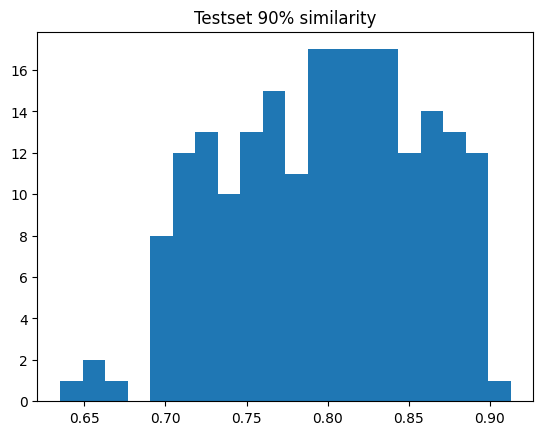

In [60]:
# For each now check the npysearch
import npysearch as npy

# Lets also look at the protein our query is the query genome and our database is going to be ecoli.
results_prot = npy.blast(query=f'../processed_data/validation_90.fasta',
                         database=f'../processed_data/train_swissprot.fasta',
                         minIdentity=0.1,
                         maxAccepts=1,
                         alphabet="protein")
results = pd.DataFrame(results_prot)  # Convert this into a dataframe so that we can see it more easily
plt.hist(results['Identity'], bins=20)
plt.title('Testset 90% similarity')


   Read database: 100.0% (58 MB)                    
Analyze database: 100.0% (168k)                    
  Index database: 100.0% (168k)                    
    Read queries: 100.0% (57 kB)                      
 Search database: 100.0% (146.0)                    


Text(0.5, 1.0, 'Price similarity')

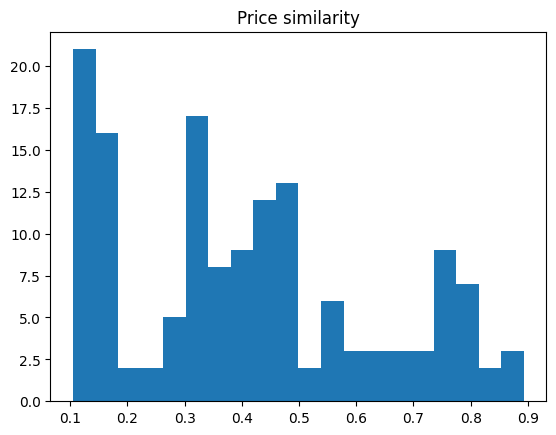

In [62]:

# Lets also look at the protein our query is the query genome and our database is going to be ecoli.
results_prot = npy.blast(query=f'../processed_data/price.fasta',
                         database=f'../processed_data/train_swissprot.fasta',
                         minIdentity=0.1,
                         maxAccepts=1,
                         alphabet="protein")
results = pd.DataFrame(results_prot)  # Convert this into a dataframe so that we can see it more easily
plt.hist(results['Identity'], bins=20)
plt.title('Price similarity')


   Read database: 100.0% (57 MB)                    
Analyze database: 100.0% (167k)                    
  Index database: 100.0% (167k)                    
    Read queries: 100.0% (213 kB)                     
 Search database: 100.0% (539.0)                    


Text(0.5, 1.0, 'Promiscuous similarity')

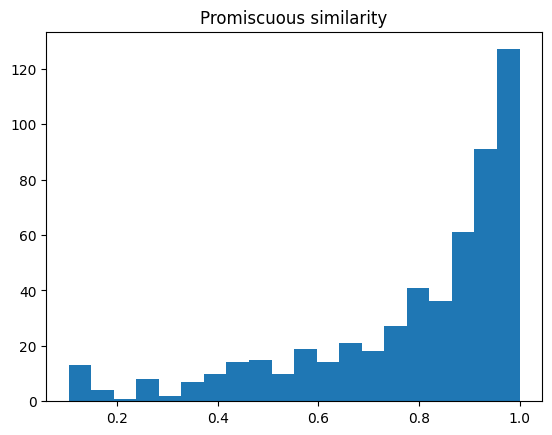

In [96]:
# Lets also look at the protein our query is the query genome and our database is going to be ecoli.
results_prot = npy.blast(query=f'../processed_data/promiscuous.fasta',
                         database=f'../processed_data/train_swissprot.fasta',
                         minIdentity=0.1,
                         maxAccepts=1,
                         alphabet="protein")
results = pd.DataFrame(results_prot)  # Convert this into a dataframe so that we can see it more easily
plt.hist(results['Identity'], bins=20)
plt.title('Promiscuous similarity')

## Mabe drop the sequneces which are > 95% similar to our dataset?
for now just skip this

In [97]:
with open(f'../processed_data/all_test_seqs.fasta', 'w+') as fout:
    for entry, seq in enumerate(test_pooled_seqs):
        fout.write(f'>{entry}\n{seq}\n')


   Read database: 100.0% (57 MB)                    
Analyze database: 100.0% (167k)                    
  Index database: 100.0% (167k)                    
    Read queries: 100.0% (213 kB)                     
 Search database: 100.0% (539.0)                    


Text(0.5, 1.0, 'Similarity from training to test')

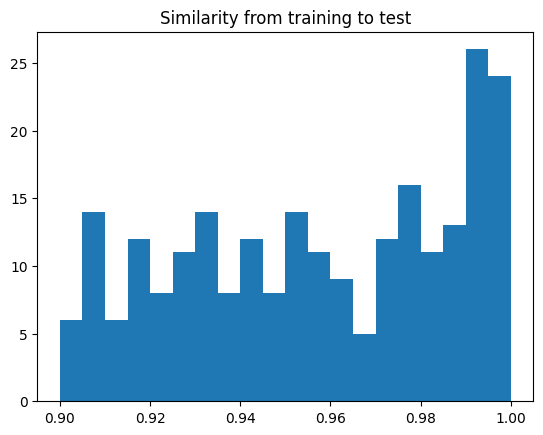

In [101]:
# Lets also look at the protein our query is the query genome and our database is going to be ecoli.
results_prot = npy.blast(query=f'../processed_data/promiscuous.fasta', # Use swiss prot to remove seqs that it's simlar to
                         database=f'../processed_data/train_swissprot.fasta',
                         minIdentity=0.90,
                         maxAccepts=1,
                         alphabet="protein")
results = pd.DataFrame(results_prot)  # Convert this into a dataframe so that we can see it more easily
plt.hist(results['Identity'], bins=20)
plt.title('Similarity from training to test')

In [102]:
len(set(results['QueryId'].values))

240

In [103]:
# Remove these from the promiscuous test dataset
promiscuous = promiscuous[~promiscuous['Entry'].isin(list(set(results['QueryId'].values)))]
promiscuous

,index,Entry,Sequence,EC number,Surprise Level,Number of ECs,Duplicated EC,Duplicated Sequence,EC simple
0,4072,P9WGT3,MTATATEGAKPPFVSRSVLVTGGNRGIGLAIAQRLAADGHKVAVTH...,"[1.1.1.100, 1.1.1.36]",1,2,True,False,1.1.1.100_1.1.1.36
2,4267,Q09851,MEAEKFVLITGCSEGGIGNALALKFHQEGFQVLATARQVERMDNLT...,"[1.1.1.101, 3.1.1.3]",4,2,True,False,1.1.1.101_3.1.1.3
4,8233,Q9R092,MWFYLVTLVGLYHLLRWYRERQVVSHLQDKYVFITGCDSGFGNLLA...,"[1.1.1.105, 1.1.1.209, 1.1.1.239, 1.1.1.53, 1....",1,5,True,False,1.1.1.105_1.1.1.209_1.1.1.239_1.1.1.53_1.1.1.62
5,2871,O54909,MWLYLVALVGLWTLLRFFRVRQVVSHLQDKYVFITGCDSGFGTLLA...,"[1.1.1.105, 1.1.1.209, 1.1.1.315, 1.1.1.53]",1,4,True,False,1.1.1.105_1.1.1.209_1.1.1.315_1.1.1.53
6,7885,Q9BPW9,MLFWVLGLLILCGFLWTRKGKLKIEDITDKYIFITGCDSGFGNLAA...,"[1.1.1.105, 1.1.1.209, 1.1.1.53]",1,3,True,False,1.1.1.105_1.1.1.209_1.1.1.53
...,...,...,...,...,...,...,...,...,...
530,3558,P36967,MISAGMIARNFGKRFFSTKPSVLINKHTKVICQGFTGNQGTFHSKQ...,"[6.2.1.4, 6.2.1.5]",1,2,True,False,6.2.1.4_6.2.1.5
533,3124,P08192,MIIKRTPQAASPLASWLSYLENLHSKTIDLGLERVSLVAARLGVLK...,"[6.3.2.12, 6.3.2.17]",1,2,True,False,6.3.2.12_6.3.2.17
534,6724,Q75UN0,MALEILGVEGIPEVDAGADLAGLIAKAGTYRDGDILLVTSKVVSKA...,"[6.3.2.31, 6.3.2.34]",1,2,True,False,6.3.2.31_6.3.2.34
535,7378,Q8IXN7,MCSQLWFLTDRRIREDYPQVQILRALRQRCSEQDVRFRAVLMDQIA...,"[6.3.2.41, 6.3.2.42]",1,2,True,False,6.3.2.41_6.3.2.42


In [57]:
# Save each to a csv for testing and validation
with open(f'../processed_data/protein2EC_train.fasta', 'w') as f:
    for entry, sequence in train_swissprot[['Entry', 'Sequence']].values:
        f.write('>{}\n{}\n'.format(entry, sequence))

In [58]:
# Save each to a csv for testing and validation
with open(f'../processed_data/price_protein_test.fasta', 'w') as f:
    for entry, sequence in price[['Entry', 'Sequence']].values:
        f.write('>{}\n{}\n'.format(entry, sequence))

In [59]:
# Save each to a csv for testing and validation
with open(f'../processed_data/validation_30.fasta', 'w') as f:
    for entry, sequence in validation_30[['Entry', 'Sequence']].values:
        f.write('>{}\n{}\n'.format(entry, sequence))

In [60]:
# Save each to a csv for testing and validation
with open(f'../processed_data/validation_50.fasta', 'w') as f:
    for entry, sequence in validation_50[['Entry', 'Sequence']].values:
        f.write('>{}\n{}\n'.format(entry, sequence))

In [61]:
# Save each to a csv for testing and validation
with open(f'../processed_data/validation_70.fasta', 'w') as f:
    for entry, sequence in validation_70[['Entry', 'Sequence']].values:
        f.write('>{}\n{}\n'.format(entry, sequence))

In [62]:
# Save each to a csv for testing and validation
with open(f'../processed_data/validation_90.fasta', 'w') as f:
    for entry, sequence in validation_90[['Entry', 'Sequence']].values:
        f.write('>{}\n{}\n'.format(entry, sequence))

In [63]:
# Save each to a csv for testing and validation
with open(f'../processed_data/promiscuous.fasta', 'w') as f:
    for entry, sequence in promiscuous[['Entry', 'Sequence']].values:
        f.write('>{}\n{}\n'.format(entry, sequence))

# Basically we can drop any sequence in the training set that had a sample > 95% similarity in the test set?

## For each of the training datasets, map the most similar sequence in the database to check for sequence similarity

In [ ]:
#save indices of train_swissprot to txt
np.savetxt('../splits/task1/protein2EC_train_indices.txt', train_swissprot.index, fmt='%d')